In [1]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, chi2
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score


# tunning hyperparamters model
import optuna

In [2]:
df = pd.read_csv('~/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('~/house-prices-advanced-regression-techniques/test.csv')


In [5]:
num_features = df.select_dtypes(exclude='object') # 37
cat_features = df.select_dtypes(include='object') # 43

In [6]:
# Функция для очистки выбросов
def remove_outliers(df, num_features):
    for col in num_features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Сохраняем без выбросов
df_clean = remove_outliers(df, num_features)

In [9]:
# Добавление новой фичи - отлогарифмированной цены: df['LogSalePrice'] = np.log(df['SalePrice'])
df_clean

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
10,11,20,RL,70.0,11200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,129500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,1445,20,RL,63.0,8500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,179600
1448,1449,50,RL,70.0,11767,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,5,2007,WD,Normal,112000
1451,1452,20,RL,78.0,9262,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,New,Partial,287090
1454,1455,20,FV,62.0,7500,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,185000


In [8]:
cat_features_test = test.select_dtypes(include='object')

for column in cat_features1.columns:
    unique_values = df[column].unique()
    print(f'Уникальные значения в столбце test {column}: {unique_values}')
    
for column in cat_features.columns:
    unique_values = df[column].unique()
    print(f'Уникальные значения в столбце train {column}: {unique_values}')

Уникальные значения в столбце test MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Уникальные значения в столбце test Street: ['Pave' 'Grvl']
Уникальные значения в столбце test Alley: [nan 'Grvl' 'Pave']
Уникальные значения в столбце test LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
Уникальные значения в столбце test LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']
Уникальные значения в столбце test Utilities: ['AllPub' 'NoSeWa']
Уникальные значения в столбце test LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Уникальные значения в столбце test LandSlope: ['Gtl' 'Mod' 'Sev']
Уникальные значения в столбце test Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Уникальные значения в столбце test Condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Уникальные значения в столб

In [10]:
pd.DataFrame(data={'NaN_count': num_features.isna().sum(), 'data_type':num_features.dtypes})

,NaN_count,data_type
Id,0,int64
MSSubClass,0,int64
LotFrontage,259,float64
LotArea,0,int64
OverallQual,0,int64
OverallCond,0,int64
YearBuilt,0,int64
YearRemodAdd,0,int64
MasVnrArea,8,float64
BsmtFinSF1,0,int64


In [17]:
# Год постройки гаража
df_clean['GarageYrBlt'].value_counts()
# Я бы удалил данный столбец

# Площадь облицовки каменной кладки в квадратных футах
df_clean['MasVnrArea'].value_counts()
# Заполним модой - 0.0 or KNN

# Длина улицы в линейных футах, соединенной с объектом недвижимости
df_clean['LotFrontage'].value_counts()
# Пока что KNN


LotFrontage
60.0     37
70.0     28
65.0     26
80.0     24
75.0     23
         ..
101.0     1
47.0      1
30.0      1
112.0     1
49.0      1
Name: count, Length: 69, dtype: int64

In [18]:
# Заполнение пропусков в ячейках

columns_to_drop = ['Id','SalePrice','GarageYrBlt']


my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', columns_to_drop),
        ('num_imputer', KNNImputer(n_neighbors=5), num_features.columns)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

In [19]:
scaler_and_encoder = ColumnTransformer(
    [
        ('scaling_num_columns', StandardScaler(), num_features.columns)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

In [20]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [21]:
df_fitted = preprocessor.fit_transform(df_clean)

In [25]:
df_fitted

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,-1.741726,0.394371,-0.255690,-0.277903,0.532102,-0.534929,0.734931,0.649381,1.072188,0.713932,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,-1.737044,0.394371,-0.057721,0.863840,0.532102,-0.534929,0.655848,0.599474,0.761472,0.166229,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,-1.732362,0.394371,0.998111,2.091213,1.341740,-0.534929,0.616306,0.499660,2.479548,0.586964,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
6,-1.727680,-0.890087,0.404205,0.388385,1.341740,-0.534929,0.774473,0.749195,0.980801,2.364508,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
10,-1.718315,-0.890087,0.074258,0.843451,-1.087173,-0.534929,-0.767649,-1.247086,-0.718998,1.211843,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,1.638753,-0.890087,-0.387669,-0.257515,0.532102,-0.534929,0.774473,0.699288,0.249705,-1.043695,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1448,1.648117,0.073257,0.074258,1.074654,-1.896811,2.403705,-2.942435,0.499660,-0.718998,-1.043695,...,Detchd,Unf,Fa,TA,Y,NaN,GdWo,NaN,WD,Normal
1451,1.655140,-0.890087,0.602174,0.053202,1.341740,-0.534929,0.932639,0.948824,1.053910,-1.043695,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,New,Partial
1454,1.662163,-0.890087,-0.453658,-0.665280,0.532102,-0.534929,0.774473,0.749195,-0.718998,-0.022977,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [46]:
X = df_fitted.drop(columns=['SalePrice'])
y = df_fitted['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,-1.730865,0.073375,-0.245897,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.509456,0.575425,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,-1.728492,-0.872563,0.397151,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.574822,1.171992,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,-1.726120,0.073375,-0.117287,0.073480,0.651479,-0.517200,0.984752,0.830215,0.321367,0.092907,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,-1.723747,0.309859,-0.460246,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.574822,-0.499274,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,-1.721374,0.073375,0.568630,0.375148,1.374795,-0.517200,0.951632,0.733308,1.361389,0.463568,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,-0.374506,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.574822,-0.973018,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,1.723747,-0.872563,0.611500,0.266407,-0.071836,0.381743,0.222975,0.151865,0.083490,0.759659,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,1.726120,0.309859,-0.203027,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.574822,-0.369871,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,1.728492,-0.872563,-0.117287,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.574822,-0.865548,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


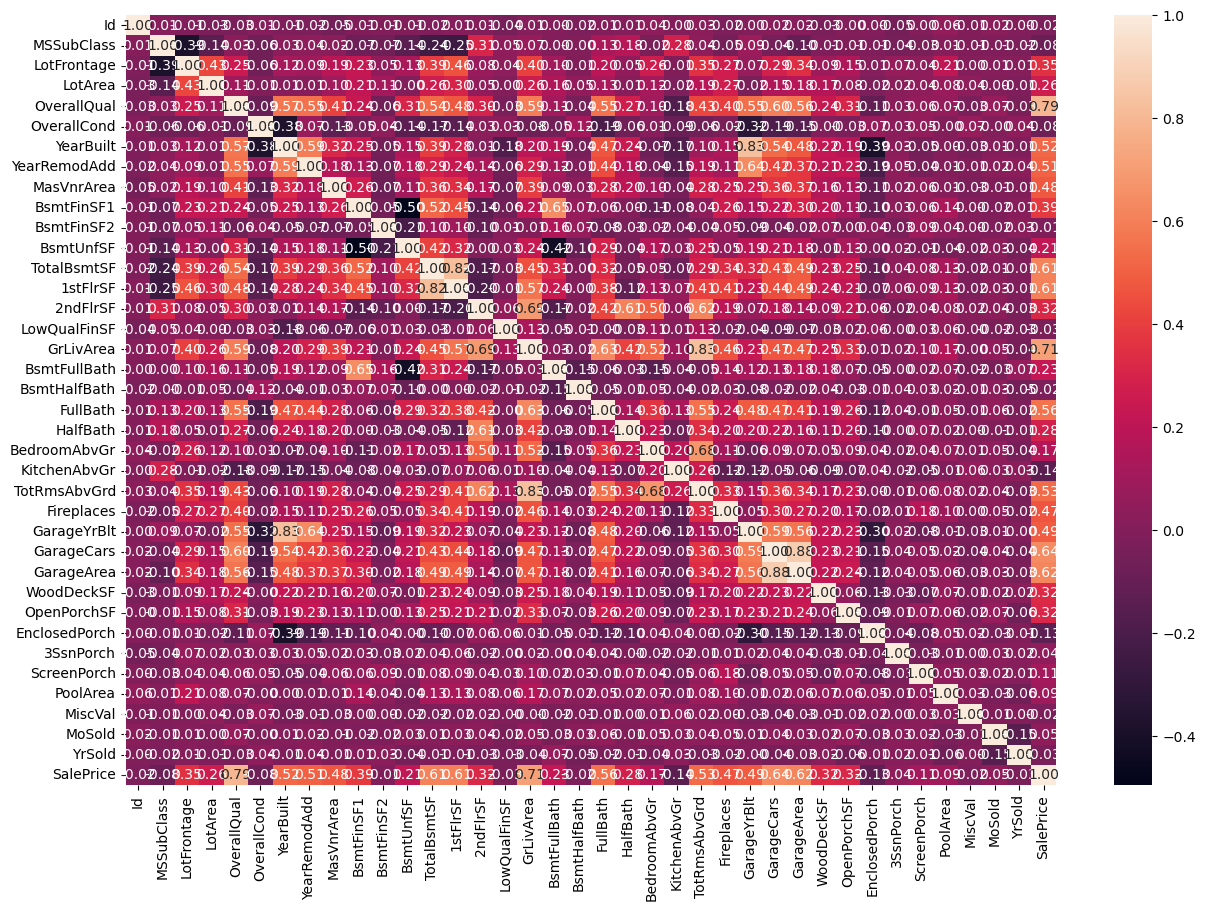

In [40]:
plt.rcParams['figure.figsize'] = [15,10]
sns.heatmap(num_features.corr(), annot=True, fmt='.2f');

In [42]:
num_features.corr()['SalePrice'][:-1].sort_values(key=lambda x: abs(x), ascending=False)

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64